# Encoders and Privacy Metrics
Exploring the effects of encoding methods on privacy metrics.

Stemmed from an issue where we noticed that uniform had lower DCR/NNDR (higher privacy risk) than generators.

## Load libraries and define settings

In [1]:
# general dependencies
import numpy as np
import pandas as pd
import sys
import os
from pathlib import Path

# synthesis methods
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.benchmark import Benchmarks

from synthesis.synthesizers.privbayes import PrivBayes
from synthesis.evaluation.metrics import MarginalComparison, AssociationsComparison

# repo code
from crnsynth.configs import config
from crnsynth.synth.custom_generators.privbayes_dk import PrivBayesDK
from crnsynth.synth.custom_generators.marginal_dk import MarginalDK
from crnsynth.synth.custom_generators.uniform_dk import UniformDK

from crnsynth.process import util
from crnsynth.evaluation import visual
from crnsynth.synth.synthpipe import BaseSynthPipe

# gives extra pandas methods for dataframes: bin_numeric_column, sample_from_binned_column
from synthesis.transformers import deidentification, generalization


/Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


[2024-01-15T20:16:19.289484+0100][8376][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-01-15T20:16:20.010643+0100][8376][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-01-15T20:16:20.011525+0100][8376][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-01-15T20:16:20.012142+0100][8376][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py


In [2]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# constants
EPSILON = 1
DATASET_NAME = 'adult'
RANDOM_SEED = 42

## Load and process dataset

In [6]:
df_adult = pd.read_csv(config.PATH_DATA[DATASET_NAME])
df_adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Generate
Here we show how step by step how to generate synthetic data.

We define our synthesis pipeline, this will help us perform all the steps the right order. You can inherit common functionality across synthesis pipelines, while also adding your own data-specific methods to it. 

This ensures that you can benefit from a defined structure without needing to re-implement the generic elements, while still having the flexbility to customize it to your needs.

In [7]:
class AdultSynthPipe(BaseSynthPipe):
    def __init__(
        self,
        generator,
        data_name="adult",
        target_column="income",
        test_size=0.2,
        output_train_format=False,
        generalize=True,
        data_loader_name="generic",
        random_state=None,
        warn=True,
        verbose=2,
    ) -> None:
        super().__init__(
            generator=generator,
            data_name=data_name,
            target_column=target_column,
            test_size=test_size,
            output_train_format=output_train_format,
            generalize=generalize,
            data_loader_name=data_loader_name,
            random_state=random_state,
            warn=warn,
            verbose=verbose,
        )

    def process_data(self, data_real):
        # reduce columns
        columns_subset = [
            "age",
            "workclass",
            "education",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "sex",
            "hours-per-week",
            "native-country",
            "income",
        ]
        data_real = data_real[columns_subset]

        return super().process_data(data_real)

    def _generalize_data(self, data_real):
        data_real = data_real.bin_numeric_column(
            column_name="age", n_bins=5, col_min=17, col_max=90, strategy="quantile"
        ).bin_numeric_column(
            column_name="hours-per-week",
            n_bins=5,
            col_min=1,
            col_max=99,
            strategy="quantile",
        )
        return super()._generalize_data(data_real)

    def _reverse_generalization(self, data_synth):
        data_synth = data_synth.sample_from_binned_column(
            column_name="age",
            numeric_type="int",
            mean=38,
            std=13,
            random_state=self.random_state,
        ).sample_from_binned_column(
            column_name="hours-per-week",
            numeric_type="int",
            mean=40,
            std=10,
            random_state=self.random_state,
        )
        return super()._reverse_generalization(data_synth)

SynthPipe allows you to perform a full synthesis pipeline step by step and allow you to inspect what happens. However, you can also use run() to perform all steps in order at once.

In [17]:
# choose generator privbayes
generator = Plugins().get('privbayes_dk', epsilon=EPSILON)
synth_pipe_pb = AdultSynthPipe(generator=generator, random_state=RANDOM_SEED)

df_train, df_test = synth_pipe_pb.process_data(df_adult)
synth_pipe_pb.fit(df_train)
df_synth_pb = synth_pipe_pb.generate()
df_synth_pb = synth_pipe_pb.postprocess_synthetic_data(df_synth_pb)

[2024-01-15T20:28:41.841222+0100][8376][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py


Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.


Using data loader for generic
1/11 - Root of network: income

2/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 10
Selected attribute: 'relationship' - with parents: ('income',)

3/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 9
Selected attribute: 'marital-status' - with parents: ('income', 'relationship')

4/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 15
Selected attribute: 'sex' - with parents: ('income', 'relationship', 'marital-status')

5/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 21
Selected attribute: 'age' - with parents: ('marital-status', 'income', 'sex')

6/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 29
Selected attribute: 'occupation' - with parents: ('income', 'sex')

7/11 - Evaluating next attribute to add to network
Number of AttributeParentPai

invalid value encountered in divide


Number of records generated: 32561 / 32561
Synthetic Data Generated

Number of records generated: 32561 / 32561
Synthetic Data Generated



In [18]:
# choose generator uniform
generator = Plugins().get('uniform_sampler_custom', epsilon=EPSILON)
synth_pipe_uniform = AdultSynthPipe(generator=generator, random_state=RANDOM_SEED)

df_train, df_test = synth_pipe_uniform.process_data(df_adult)
synth_pipe_uniform.fit(df_train)
df_synth_uniform = synth_pipe_uniform.generate()
df_synth_uniform = synth_pipe_uniform.postprocess_synthetic_data(df_synth_pb)

[2024-01-15T20:29:58.104780+0100][8376][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.


Using data loader for generic
Uniform fitted: age
Uniform fitted: workclass
Uniform fitted: education
Uniform fitted: marital-status
Uniform fitted: occupation
Uniform fitted: relationship
Uniform fitted: race
Uniform fitted: sex
Uniform fitted: hours-per-week
Uniform fitted: native-country
Uniform fitted: income
Column sampled: age
Column sampled: workclass
Column sampled: education
Column sampled: marital-status
Column sampled: occupation
Column sampled: relationship
Column sampled: race
Column sampled: sex
Column sampled: hours-per-week
Column sampled: native-country
Column sampled: income


## Metrics
Below an example on how to compute a privacy metric. Note the synthetic score (DCR and NNDR) > test score to minimize privacy leakage.

In [19]:
from crnsynth.evaluation.custom_privacy_metrics.utils import compute_distance_nn
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from synthcity.plugins.core.dataloader import create_from_info

In [20]:
def get_column_transformer(df, categorical_cols=None):
    # define column types
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(exclude=np.number).columns
        numeric_cols = df.select_dtypes(include=np.number).columns
    else:
        numeric_cols = df.columns.difference(categorical_cols)

    transformer = make_column_transformer(
        (SimpleImputer(missing_values=np.nan, strategy="mean"), numeric_cols),
        (OneHotEncoder(sparse_output=False), categorical_cols), # sparse_ouput = False to convert to pandas
        remainder="passthrough",
    )

    # ensure output is dataframe
    transformer.set_output(transform='pandas')
    return transformer

def custom_encode(loader, encoders=None):
    """Run custom encoders on synthcity dataloader, as their implementation does not work with anything other than LabelEncoders.
    """
    df = loader.dataframe().copy()

    # fit encoders on data
    if encoders is None:
        encoders = get_column_transformer(df)
        encoders.fit(df)

    # transform data
    df_encoded = encoders.transform(df)
    loader_enc = GenericDataLoader(df_encoded)
    return loader_enc, encoders
    

In [28]:
# convert to dataloaders
loader_real = GenericDataLoader(df_train, random_state=RANDOM_SEED)
loader_test = GenericDataLoader(df_test, random_state=RANDOM_SEED)
loader_synth_uniform = GenericDataLoader(df_synth_uniform, random_state=RANDOM_SEED)
loader_synth_pb = GenericDataLoader(df_synth_pb, random_state=RANDOM_SEED)

# encoding methods native (synthcity) vs custom
loaders_synth = [loader_synth_uniform, loader_synth_pb]
algorithm_names = ['uniform', 'privbayes']
encoding_methods = ['custom', 'native', 'native_refit']

distances = {}


# compute stats per synthetic dataset
for name, loader_synth in zip(algorithm_names, loaders_synth):
    distances[name] = {}

    for encoding_method in encoding_methods:
        print(f"Algorithm: {name} and encoding_method: {encoding_method}")

        # standard synthcity encoding using labelencoder
        if encoding_method == 'native':
            # fit and transform encoders on real
            loader_real_enc, encoders = loader_real.encode(encoders=None)
            loader_test
            # use fitted transformer to encode synth data 
            loader_synth_enc, _ = loader_synth.encode(encoders=encoders)

        elif encoding_method == 'custom':
            loader_real_enc, encoders = custom_encode(loader_real, encoders=None)
            loader_synth_enc, _ = custom_encode(loader_synth, encoders=encoders)
        
        elif encoding_method == 'native_refit':
            # old way of fitting encoders on real and synth data (re-fit)
            loader_real_enc, encoders = loader_real.encode(encoders=None)
            loader_synth_enc, _ = loader_synth.encode(encoders=None)

        else:
            raise ValueError(f"unknown encoding method: {encoding_method}")


        distances_test, distances_synth = compute_distance_nn(
            df_train=loader_real_enc.dataframe(),
            df_test=loader_real_enc.dataframe(),
            df_synth=loader_synth_enc.dataframe(),
        )

        distances[name][encoding_method] = {
            'test': distances_test,
            'synth': distances_synth
        }

Algorithm: uniform and encoding_method: custom


KeyboardInterrupt: 



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating you

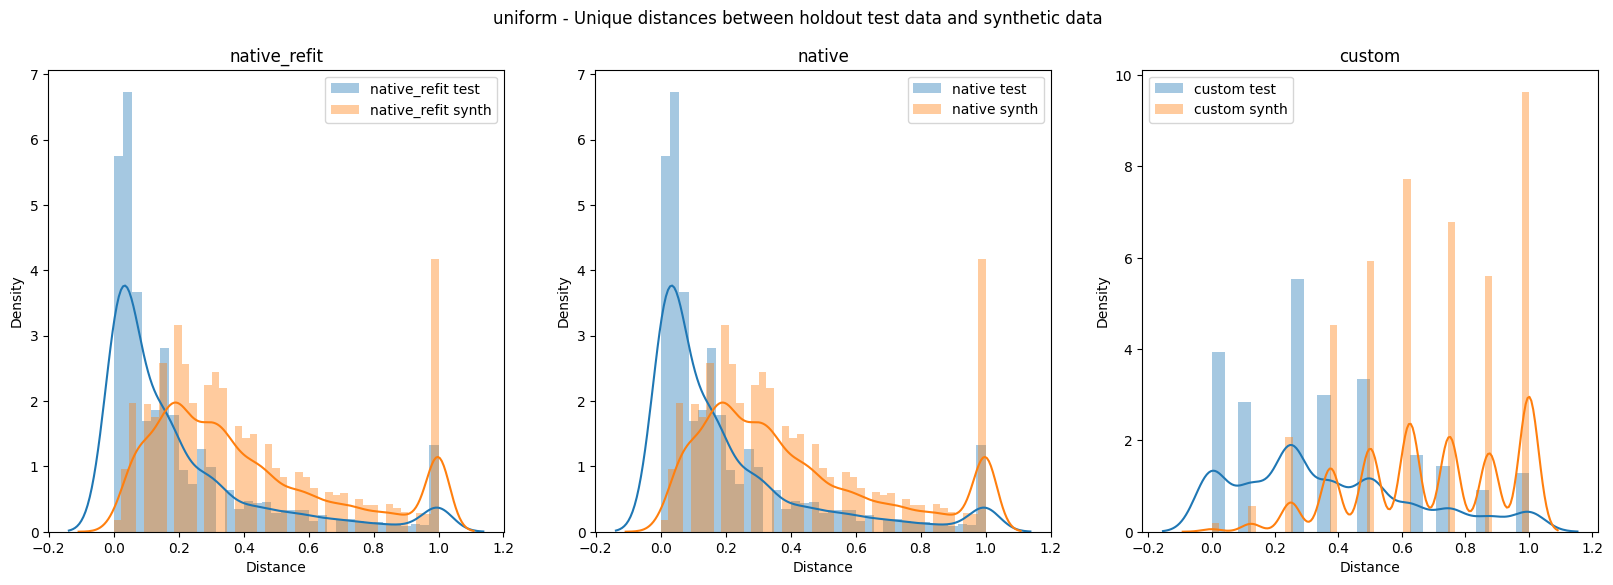

In [23]:
def plot_distances(distances, order, title_suffix=None):
    n_plots = len(distances)
    fig, ax = plt.subplots(1, n_plots, figsize=(20, 6))

    # plot unique distances

    for i, encoding_method in enumerate(order):
        sns.distplot(distances[encoding_method]['test'][:, 0], ax=ax[i], label=f'{encoding_method} test')
        sns.distplot(distances[encoding_method]['synth'][:, 0], ax=ax[i], label=f'{encoding_method} synth')

        ax[i].legend()
        ax[i].set_title(f"{encoding_method}")
        ax[i].set_xlabel("Distance")
        ax[i].set_ylabel("Density")

    # title
    fig.suptitle(f"{title_suffix} - Unique distances between holdout test data and synthetic data")
    plt.show()

# include keys
order = ['native_refit', 'native', 'custom']
algorithm = 'uniform'
plot_distances(distances[algorithm], order=order, title_suffix=algorithm)

In [26]:
distances['uniform']['custom']['synth']

array([[1.   , 1.   ],
       [0.625, 0.75 ],
       [0.75 , 0.75 ],
       ...,
       [0.625, 0.625],
       [1.   , 1.   ],
       [0.75 , 0.875]])

In [27]:
distances['privbayes']['custom']['synth']

array([[1.   , 1.   ],
       [0.625, 0.75 ],
       [0.75 , 0.75 ],
       ...,
       [0.625, 0.625],
       [1.   , 1.   ],
       [0.75 , 0.875]])



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating you

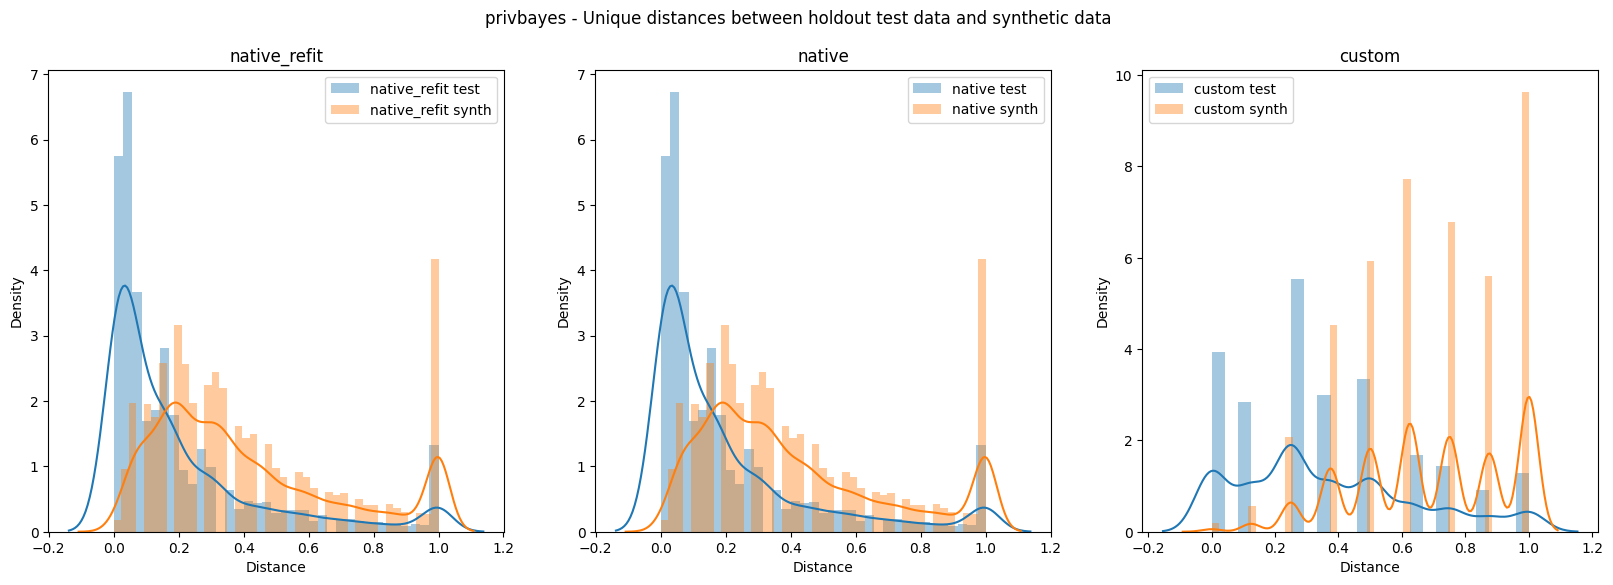

In [24]:
algorithm = 'privbayes'
plot_distances(distances[algorithm], order=order, title_suffix=algorithm)

Test distances [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] with counts [  58  155  851 1968 3623 5697 5642 5683 8884]
Synthetic distances: [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] with counts [  58  155  851 1968 3623 5697 5642 5683 8884]




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Text(0.5, 1.0, 'Distribution of distances to nearest neighbor')

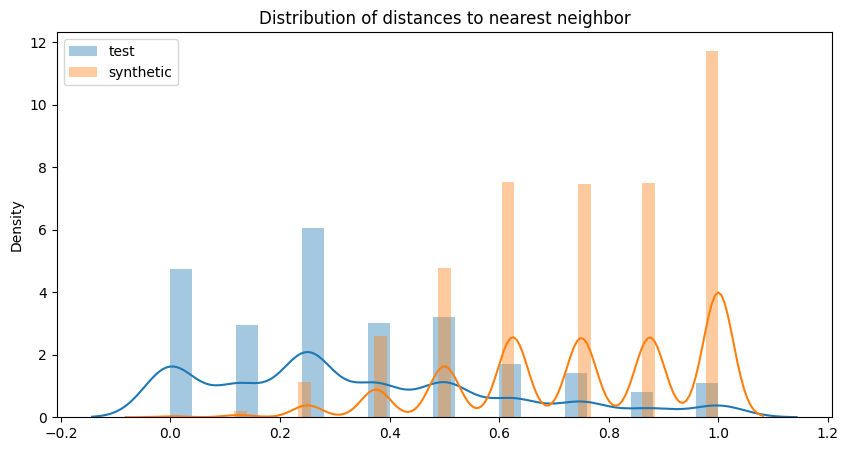

In [62]:
from crnsynth.evaluation.custom_privacy_metrics.utils import compute_distance_nn
import matplotlib.pyplot as plt
import seaborn as sns

distances_test, distances_synth = compute_distance_nn(
    df_train=df_train,
    df_test=df_test,
    df_synth=df_synth,
    categorical_cols=None,
)

# print distances test and synthetic with counts
dt, ct  = np.unique(distances_test[:, 0], return_counts=True)
dt, ct = np.unique(distances_synth[:, 0], return_counts=True)


print(f'Test distances {dt} with counts {ct}')
print(f'Synthetic distances: {dt} with counts {ct}')

# plot distances as distribution in same figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(distances_test[:, 0], ax=ax, label='test')

# plot 5th percentile  and median test
percentile_test = np.percentile(distances_test[:, 0], percentile)
median_test = np.median(distances_test[:, 0])
ax.axvline(percentile_test, color='red', label=f'{percentile}th percentile')
ax.axvline(median_test, color='green', label='median')

sns.distplot(distances_synth[:, 0], ax=ax, label='synthetic')
# plot median synthetic
median_synth = np.median(distances_synth[:, 0])

ax.legend()
ax.set_title(f'Distribution of distances to nearest neighbor')

In [26]:
distances_synth

array([[0.875, 1.   ],
       [0.625, 0.75 ],
       [0.375, 0.375],
       ...,
       [0.75 , 0.875],
       [0.5  , 0.625],
       [0.375, 0.375]])

In [27]:
distances_test

array([[0.   , 0.125],
       [1.   , 1.   ],
       [0.375, 0.625],
       ...,
       [0.875, 0.875],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ]])

In [32]:
np.percentile(distances_test[:, 0], 50)

0.25

In [37]:
np.percentile(distances_synth[:, 0], 50)

0.7499999999999998

In [39]:
np.unique(distances_test[:, 0], return_counts=True)

(array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
 array([1240,  766, 1576,  788,  836,  441,  372,  207,  287]))

In [48]:
df_concat_unique = pd.concat([df_train.drop_duplicates(keep=False), df_test])
df_dup = df_concat_unique[df_concat_unique.duplicated(keep='first')]

In [49]:
df_dup

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
13077,57,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,<=50K
21997,34,Private,HS-grad,Divorced,Machine-op-inspct,Unmarried,White,Female,40,United-States,<=50K
22684,54,Private,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,>50K
8964,22,Private,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Female,30,United-States,<=50K
8215,22,Private,HS-grad,Never-married,Other-service,Own-child,White,Female,35,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
24643,53,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,46,United-States,>50K
7672,33,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,<=50K
14344,19,?,Some-college,Never-married,?,Own-child,White,Female,40,United-States,<=50K
8270,43,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,>50K
